In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random
import seaborn as sns

# navigation and read files
import glob
import os

# Read HDF5 binary data format: convenient for large data storage
import h5py

# Read and display images
import matplotlib.pyplot as plt
import imageio
import cv2
from cv2 import imshow
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow import keras

# DL dependancies
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [ ]:
data1=pd.read_csv("/content/drive/MyDrive/Dataset/handwriting/letters.csv")
data2=pd.read_csv("/content/drive/MyDrive/Dataset/handwriting/letters2.csv")
data3=pd.read_csv("/content/drive/MyDrive/Dataset/handwriting/letters3.csv")

In [ ]:
print("First Dataset shape: {},\nSecond Dataset Shape: {},\nThird Dataset shape: {}".format(data1.shape,data2.shape,data3.shape))

First Dataset shape: (1650, 4),
Second Dataset Shape: (5940, 4),
Third Dataset shape: (6600, 4)


In [ ]:
data1.head()

,letter,label,file,background
0,а,1,01_01.png,0
1,а,1,01_02.png,0
2,а,1,01_03.png,0
3,а,1,01_04.png,0
4,а,1,01_05.png,0


In [ ]:
#read the h5 File
f=h5py.File("/content/drive/MyDrive/Dataset/handwriting/LetterColorImages_123.h5","r")
#list all Groups
keys=list(f.keys())
keys

'backgrounds'

In [ ]:
n=f.get('data1')

In [ ]:
n = np.array(n)
n.shape

()

In [ ]:
#create Tensors and targets of Images
img_backgrounds=np.array(f[keys[0]])
img_tensors=np.array(f[keys[1]])
targets=np.array(f[keys[2]])
print('Tensor Shape',img_tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', img_backgrounds.shape)

Tensor Shape (14190, 32, 32, 3)
Target shape (14190,)
Background shape: (14190,)


In [ ]:
# Concatenate series
letters = pd.concat((data1["letter"], data2["letter"]), axis=0, ignore_index=True)
letters = pd.concat((letters, data3["letter"]), axis=0, ignore_index=True)
len(letters)

14190

In [ ]:
# Normalize the tensors
img_tensors = img_tensors/255
img_tensors[0][0][0][0]

0.76862746

Visualization

Lets see the distributions of data in dataset to find out if there are any unbalanced classes:

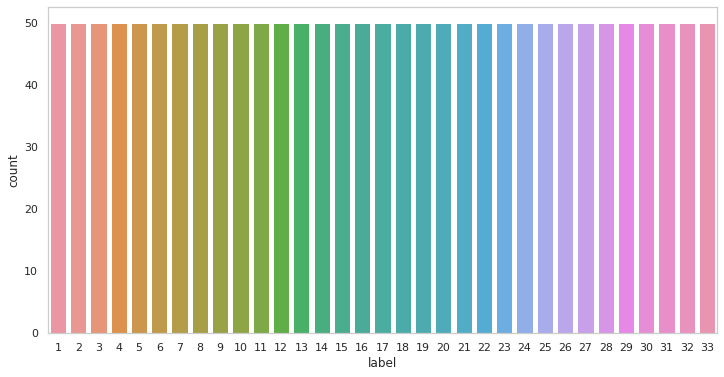

In [ ]:
sns.countplot(x="label", data=data1) 

<HDF5 file "LetterColorImages_123.h5" (mode r)>

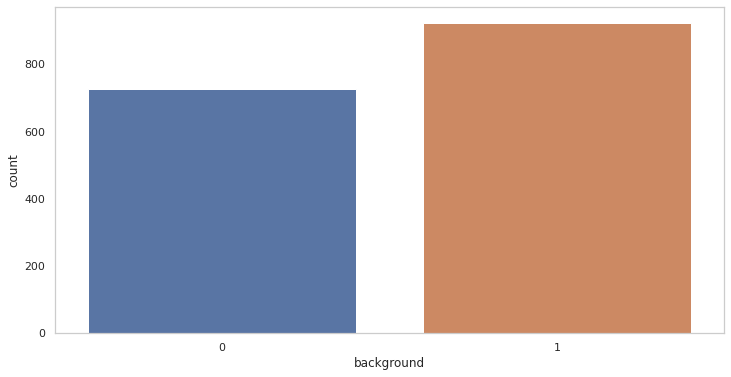

In [ ]:
sns.countplot(x="background", data=data1)

Label:  б


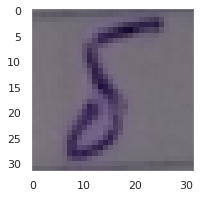

In [ ]:
# Read and display a tensor using Matplotlib
sns.set_style("darkgrid", {'axes.grid' : False})
print('Label: ', letters[50])
plt.figure(figsize=(3,3))
plt.imshow(img_tensors[50]);

In [ ]:
img_tensors[0].shape

(32, 32, 3)

In [ ]:
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("whitegrid", {'axes.grid' : False})

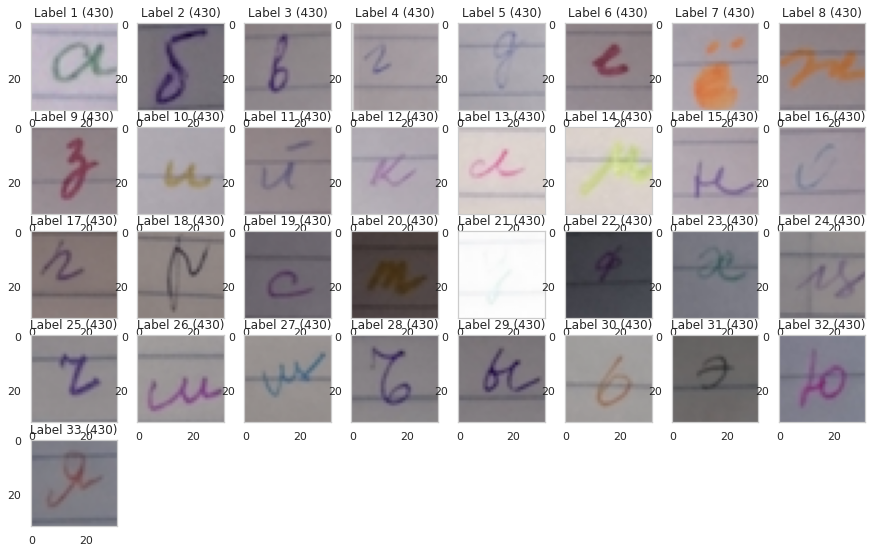

In [ ]:
#Display the First Image of Each Label
def display_images_and_labels(images,labels):
  unique_lables=set(labels)
  plt.figure(figsize=(15,15))
  i=1
  labels=labels.tolist()
  for label in unique_lables:
    #pick the first image of each label
    image=images[labels.index(label)]
    plt.subplot(8,8,i)
    plt.title("Label {} ({})".format(label,labels.count(label)))
    i+=1
    plt.imshow(image)
  plt.show()

display_images_and_labels(img_tensors,targets)




As We can see image Label 21 that it is not clearly visiible . Try to find out more images like this

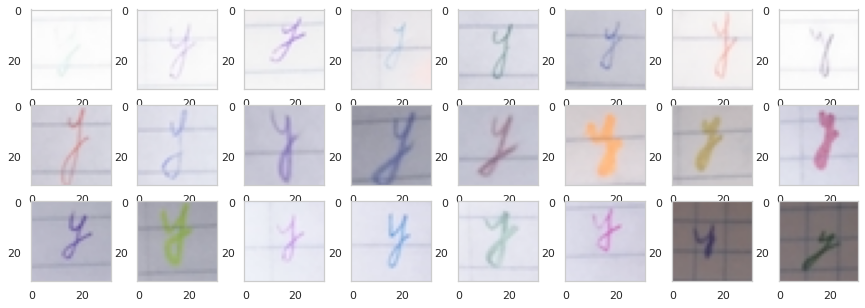

In [ ]:
def display_label_images(images,labels,label):
  limit=24
  plt.figure(figsize=(15,5))
  i=1
  labels=labels.tolist()
  start=labels.index(label)
  end=start+labels.count(label)
  for image in images[start:end][:limit]:
    plt.subplot(3,8,i)
    i+=1
    plt.imshow(image)
  plt.show()
display_label_images(img_tensors,targets,21)

Total  unique Letters 

In [ ]:
letters.unique()

array(['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л',
       'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш',
       'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], dtype=object)

In [ ]:
dictionary = {'num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],\
              "letter":['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л',
       'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш',
       'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']}
letter_dict = pd.DataFrame.from_dict(dictionary)
letter_dict = letter_dict.set_index("num")
letter_dict.head()

,letter
num,
1,а
2,б
3,в
4,г
5,д


In [ ]:
!pip install keras.utils

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
targets

array([ 1,  1,  1, ..., 33, 33, 33])

In [ ]:
#One-hot encoding the targets, started from the zero label

coded_targets = to_categorical(np.array(targets-1), 33)
coded_targets.shape

(14190, 33)

Lets convert RGB image to Grayscale to simplify structure of model of neuron network

In [ ]:
import tensorflow as tf


In [ ]:
from tensorflow import image
from tensorflow.image import rgb_to_grayscale
img_tensors_gs_tf = rgb_to_grayscale(img_tensors)

sess = tf.compat.v1.Session()
with sess.as_default():
    arr_img_tensors_gs_tf = img_tensors_gs_tf.numpy()

In [ ]:
img_tensors_gs = arr_img_tensors_gs_tf
for image in img_tensors_gs[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 1), min: 0.430990606546402, max: 0.7638980746269226
shape: (32, 32, 1), min: 0.4859851002693176, max: 0.6988815665245056
shape: (32, 32, 1), min: 0.33044904470443726, max: 0.738740861415863
shape: (32, 32, 1), min: 0.39237216114997864, max: 0.8238345384597778
shape: (32, 32, 1), min: 0.2929592430591583, max: 0.6343545317649841


In [ ]:
img_tensors_gs.shape

(14190, 32, 32, 1)

In [ ]:
#Split the data to test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_tensors_gs, coded_targets, test_size = 0.2, random_state = 1)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (11352, 32, 32, 1), 
Test dataset shape: (2838, 32, 32, 1)


In [ ]:
# Split the test data to validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)
print("Validation dataset shape: {0}, \nTest dataset shape: {1}".format(X_valid.shape, X_test.shape))

Validation dataset shape: (1419, 32, 32, 1), 
Test dataset shape: (1419, 32, 32, 1)


In [ ]:
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU, Softmax
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [ ]:
def model():
    model = Sequential()
    
    # Define a model architecture    
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.2)) 
    
    model.add(Dense(33))
    model.add(Activation('softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])#, top_3_categorical_accuracy])
    return model

model = model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [ ]:
# Train the model
# batch size = 473 as it divides X_train size, X_test and X_valid sizes evenly
score=model.fit(X_train, y_train, epochs=150, batch_size=473)#, verbose=1, validation_data=(X_valid, y_valid), callbacks=callbacks)    

Epoch 1/150
24/24 [==============================] - 26s 1s/step - loss: 0.1260 - categorical_accuracy: 0.9587
Epoch 2/150
24/24 [==============================] - 26s 1s/step - loss: 0.1199 - categorical_accuracy: 0.9597
Epoch 3/150
24/24 [==============================] - 26s 1s/step - loss: 0.1069 - categorical_accuracy: 0.9643
Epoch 4/150
24/24 [==============================] - 25s 1s/step - loss: 0.1069 - categorical_accuracy: 0.9654
Epoch 5/150
24/24 [==============================] - 25s 1s/step - loss: 0.0982 - categorical_accuracy: 0.9678
Epoch 6/150
24/24 [==============================] - 25s 1s/step - loss: 0.1008 - categorical_accuracy: 0.9666
Epoch 7/150
24/24 [==============================] - 25s 1s/step - loss: 0.1024 - categorical_accuracy: 0.9649
Epoch 8/150
24/24 [==============================] - 25s 1s/step - loss: 0.1080 - categorical_accuracy: 0.9634
Epoch 9/150
24/24 [==============================] - 26s 1s/step - loss: 0.0995 - categorical_accuracy: 0.9683
E

In [ ]:
loss,score = model.evaluate(X_test, y_test)
print("Accuracy",round(score*100,2),'%')
print("Loss",loss)

45/45 [==============================] - 1s 24ms/step - loss: 0.2927 - categorical_accuracy: 0.9281
Accuracy 92.81 %
Loss 0.2927224934101105
